In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from CapsuleNet import CapsuleNetwork, CapsuleLoss

In [2]:
seed = 41
batch_size = 20
image_size = 28
num_classes = 10

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/mnist', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='/mnist', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

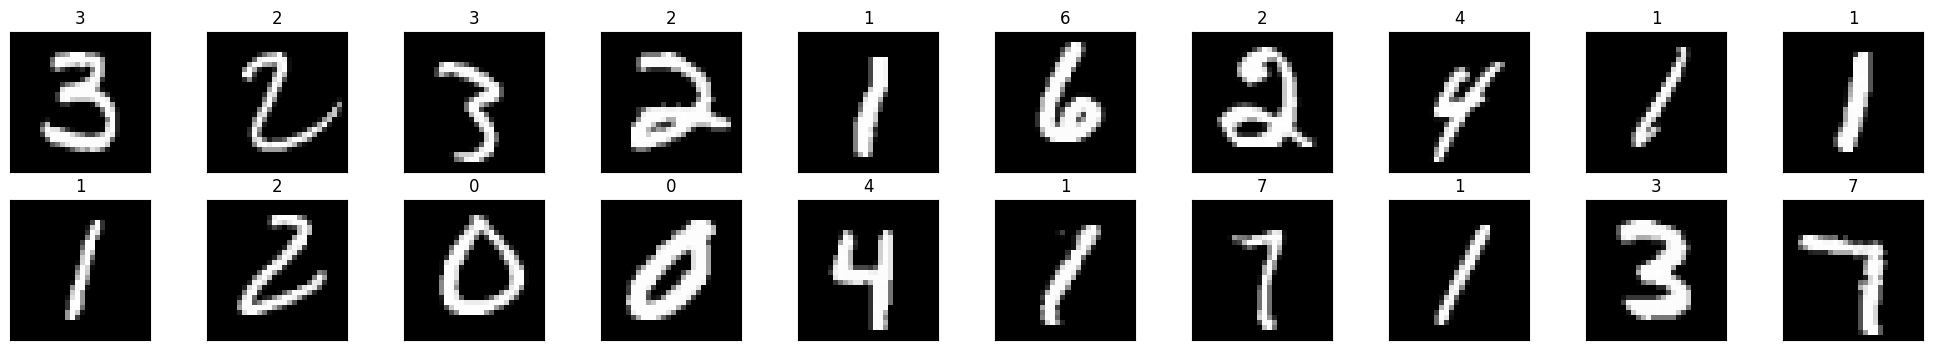

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [6]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


In [7]:
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=num_classes, train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [9]:
n_epochs = 3
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs)
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

Epoch: 1 	Training Loss: 0.26103451
Epoch: 1 	Training Loss: 0.09508012
Epoch: 1 	Training Loss: 0.07377835
Epoch: 1 	Training Loss: 0.05941177
Epoch: 1 	Training Loss: 0.05253754
Epoch: 1 	Training Loss: 0.05263326
Epoch: 1 	Training Loss: 0.05123222
Epoch: 1 	Training Loss: 0.04589066
Epoch: 1 	Training Loss: 0.04435865
Epoch: 2 	Training Loss: 0.03556920
Epoch: 2 	Training Loss: 0.03369053
Epoch: 2 	Training Loss: 0.03597139
Epoch: 2 	Training Loss: 0.03624906
Epoch: 2 	Training Loss: 0.03429614
Epoch: 2 	Training Loss: 0.03332833
Epoch: 2 	Training Loss: 0.03525289
Epoch: 2 	Training Loss: 0.03192290
Epoch: 2 	Training Loss: 0.03212777
Epoch: 3 	Training Loss: 0.02618361
Epoch: 3 	Training Loss: 0.02530367
Epoch: 3 	Training Loss: 0.02629504
Epoch: 3 	Training Loss: 0.02664904
Epoch: 3 	Training Loss: 0.02702716
Epoch: 3 	Training Loss: 0.02518718
Epoch: 3 	Training Loss: 0.02751014
Epoch: 3 	Training Loss: 0.02773804
Epoch: 3 	Training Loss: 0.02457294
Test Loss: 0.03056264

Test 

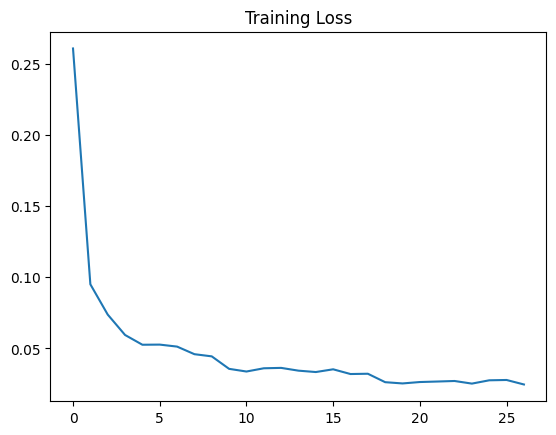

In [10]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [11]:
def display_images(images, reconstructions):
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, image_size, image_size)
    reconstructions = reconstructions.data.cpu().numpy()
    fig, axs = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))
    for images, row in zip([images, reconstructions], axs):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

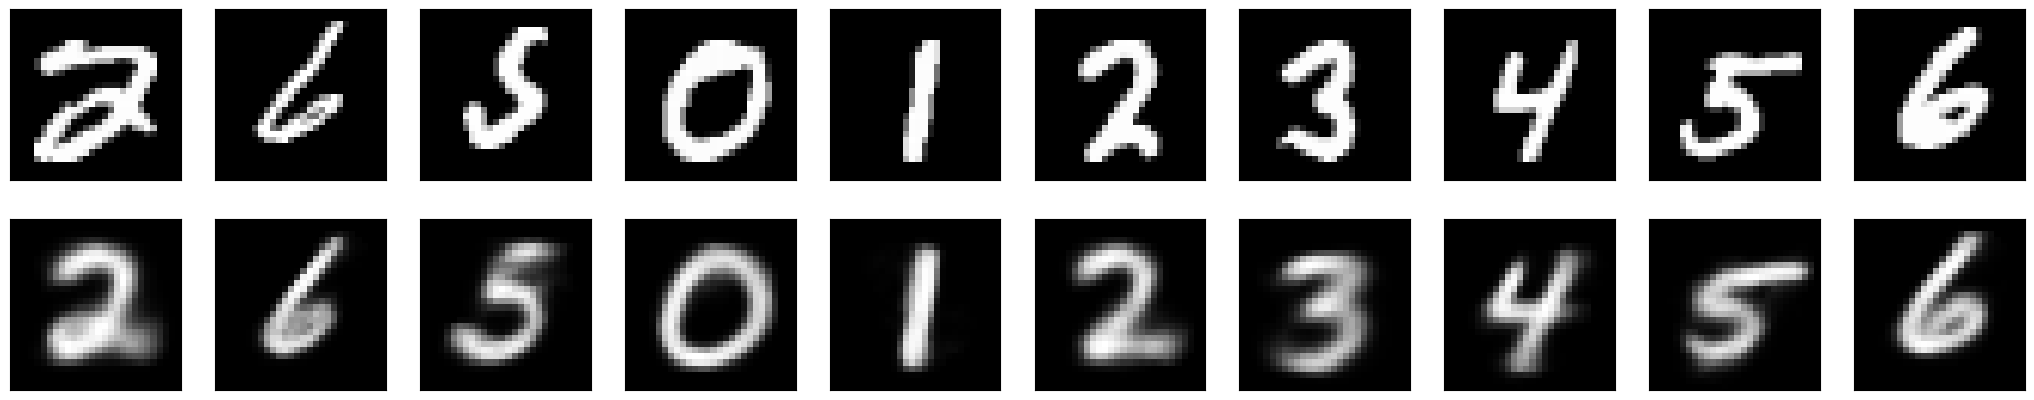

In [12]:
display_images(images, reconstructions)

In [13]:
# convert data to Tensor *and* perform random affine transformation
transform = transforms.Compose(
    [transforms.RandomAffine(degrees=30, translate=(0.1,0.1)),
     transforms.ToTensor()]
    )

# test dataset
transformed_test_data = datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, batch_size=batch_size)

# call test function and get reconstructed images
_, images, reconstructions = capsule_net.test_model(criterion, transformed_test_loader)

Test Loss: 0.26891483

Test Accuracy of     0: 92% (903/980)
Test Accuracy of     1: 87% (996/1135)
Test Accuracy of     2: 88% (911/1032)
Test Accuracy of     3: 85% (865/1010)
Test Accuracy of     4: 85% (843/982)
Test Accuracy of     5: 92% (824/892)
Test Accuracy of     6: 79% (761/958)
Test Accuracy of     7: 75% (781/1028)
Test Accuracy of     8: 75% (738/974)
Test Accuracy of     9: 75% (763/1009)

Test Accuracy (Overall): 83% (8385/10000)
